In [1]:
import os
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.fft import fft

In [2]:
from tqdm import tqdm

def load_segmented_files(directory, target_sr=32000):
    wav_files = []
    leak_wav_files = []
    for dir in os.listdir(directory):
        if not os.path.isdir(os.path.join(directory, dir)):
            continue
        for file in tqdm(os.listdir(os.path.join(directory, dir))):
            if not file.endswith(".wav"):
                continue
            file_path = os.path.join(directory, dir, file)
            y, sr = librosa.load(file_path, sr=None, mono=True)
            # print(f"檔案 {file_path} 的取樣率為 {sr}")
            if sr != target_sr:
                y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
            filename = f'{dir}_{file}'
            if 'no-leak' in dir:
                wav_files.append((y, filename))
            else:
                leak_wav_files.append((y, filename))
    print(f"共有 {len(wav_files) + len(leak_wav_files)} 個 wav 檔案，其中 {len(leak_wav_files)} 個有泄漏，{len(wav_files)} 個沒有泄漏")
    return wav_files, leak_wav_files

def shuffle_data(wav_files, leak_wav_files, n_files=None):
    wav_files = random.sample(wav_files, n_files if n_files else len(wav_files))
    leak_wav_files = random.sample(leak_wav_files, n_files if n_files else len(leak_wav_files))

    return wav_files, leak_wav_files


In [14]:
# 載入訓練資料
wav_files, leak_wav_files = load_segmented_files('validate_data/2024-10-29', target_sr=32000)

100%|██████████| 7/7 [00:00<00:00, 27.60it/s]

共有 14 個 wav 檔案，其中 7 個有泄漏，7 個沒有泄漏


In [17]:
def compute_fft(data, sample_rate, N=2048):
    """
    計算給定數據的 FFT 並返回頻率和幅值。

    參數:
        data: numpy array, 音頻數據樣本
        sample_rate: int, 音頻的採樣率
        N: int, FFT 計算的樣本數 (默認為 2048)

    返回:
        frequencies: numpy array, 頻率陣列
        fft_magnitude: numpy array, FFT 幅值陣列
    """
    data_segment = data[:N]  # 截取 N 個樣本
    fft_result = fft(data_segment)  # 計算 FFT
    fft_magnitude = np.abs(fft_result[:N // 2])  # 僅保留前一半的幅值
    frequencies = np.fft.fftfreq(N, 1 / sample_rate)[:N // 2]  # 計算頻率軸
    return frequencies, fft_magnitude

In [18]:
def extract_features_v1(audio, sr, n_mels=128, n_fft=2048, hop_length=512, enhanced=1.5, desired_time=2.0):
    """
    提取 Mel 頻譜圖特徵，並根據目標時間長度進行填充或截斷，
    確保時間幀數是 2 的冪次倍數。

    Args:
        audio (np.ndarray): 音訊資料。
        sr (int): 取樣率。
        n_mels (int): Mel 頻帶數。
        n_fft (int): FFT 大小。
        hop_length (int): hop length。
        desired_time (float): 目標時間長度（秒）。

    Returns:
        np.ndarray: 處理後的 Mel 頻譜圖，形狀為 (target_len, n_mels)。
    """
    max_len = int(np.ceil((desired_time * sr) / hop_length))
    # 計算下個 2 的冪次倍數
    target_len = int(np.ceil(max_len / 8) * 8)

    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length, center=False
    )
    mel_enhanced = mel_spectrogram * enhanced
    log_mel_spectrogram = librosa.power_to_db(mel_enhanced, ref=np.max)
    # log_mel_spectrogram = log_mel_spectrogram.T  # 形狀變為 (時間, n_mels)

    # 填充或截斷至 target_len
    if log_mel_spectrogram.shape[0] < target_len:
        pad_width = target_len - log_mel_spectrogram.shape[0]
        log_mel_spectrogram = np.pad(
            log_mel_spectrogram, ((0, pad_width), (0, 0)), mode='constant'
        )
    else:
        log_mel_spectrogram = log_mel_spectrogram[:target_len, :]

    return log_mel_spectrogram

In [28]:
def extract_stft_features(audio, sr, n_fft=2048, hop_length=512, desired_time=2.0):

    max_len = int(np.ceil((desired_time * sr) / hop_length))
    # 計算下個 2 的冪次倍數
    target_len = int(np.ceil(max_len / 8) * 8)


    # 計算 STFT
    D = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length, window='hamming')
    # 計算幅度譜
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    # 填充或截斷至 target_len
    if S_db.shape[0] < target_len:
        pad_width = target_len - S_db.shape[0]
        S_db = np.pad(S_db, ((0, pad_width), (0, 0)), mode='constant')
    else:
        S_db = S_db[:target_len, :]

    return S_db

In [44]:
def plot_mel_stft_fft(wav, file_name, class_type:str):
    mel_spectrogram = extract_features_v1(wav, sr=32000, n_mels=128, n_fft=1024, hop_length=256, enhanced=1)
    S_db = extract_stft_features(wav, sr=32000, n_fft=512, hop_length=128)
    frequencies, fft_magnitude = compute_fft(wav, sample_rate=32000, N=1024)

    fig, axs = plt.subplots(3, 1, figsize=(10, 12))
    # 繪製 Mel 頻譜圖
    librosa.display.specshow(mel_spectrogram, sr=32000, hop_length=256, x_axis='time', y_axis='mel', cmap='jet', ax=axs[0])

    axs[0].set_title(f'Mel Spectrogram {file_name}')
    axs[0].set_ylim(0, 1600)
    axs[0].set_yticks(np.arange(0, 1600, 150))
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Frequency (Hz)')

    # 繪製 STFT 頻譜圖
    librosa.display.specshow(S_db, sr=32000, hop_length=128, x_axis='time', y_axis='log', cmap='jet', ax=axs[1])
    axs[1].set_title(f'STFT Magnitude {file_name}')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Frequency (Hz)')

    # 繪製 FFT 頻譜圖
    axs[2].plot(frequencies, fft_magnitude)
    axs[2].set_xlim(0, 3600)
    axs[2].set_title(f"FFT of Audio Signal {file_name}")
    axs[2].set_xlabel("Frequency (Hz)")
    axs[2].set_ylabel("Magnitude")
    axs[2].grid(True)
    
    # make sure directory exists
    os.makedirs(f"images/{class_type}", exist_ok=True)
    plt.tight_layout()
    plt.savefig(f"images/{class_type}/{file_name}_mel_stft_fft.png")
    plt.show()
    plt.close()


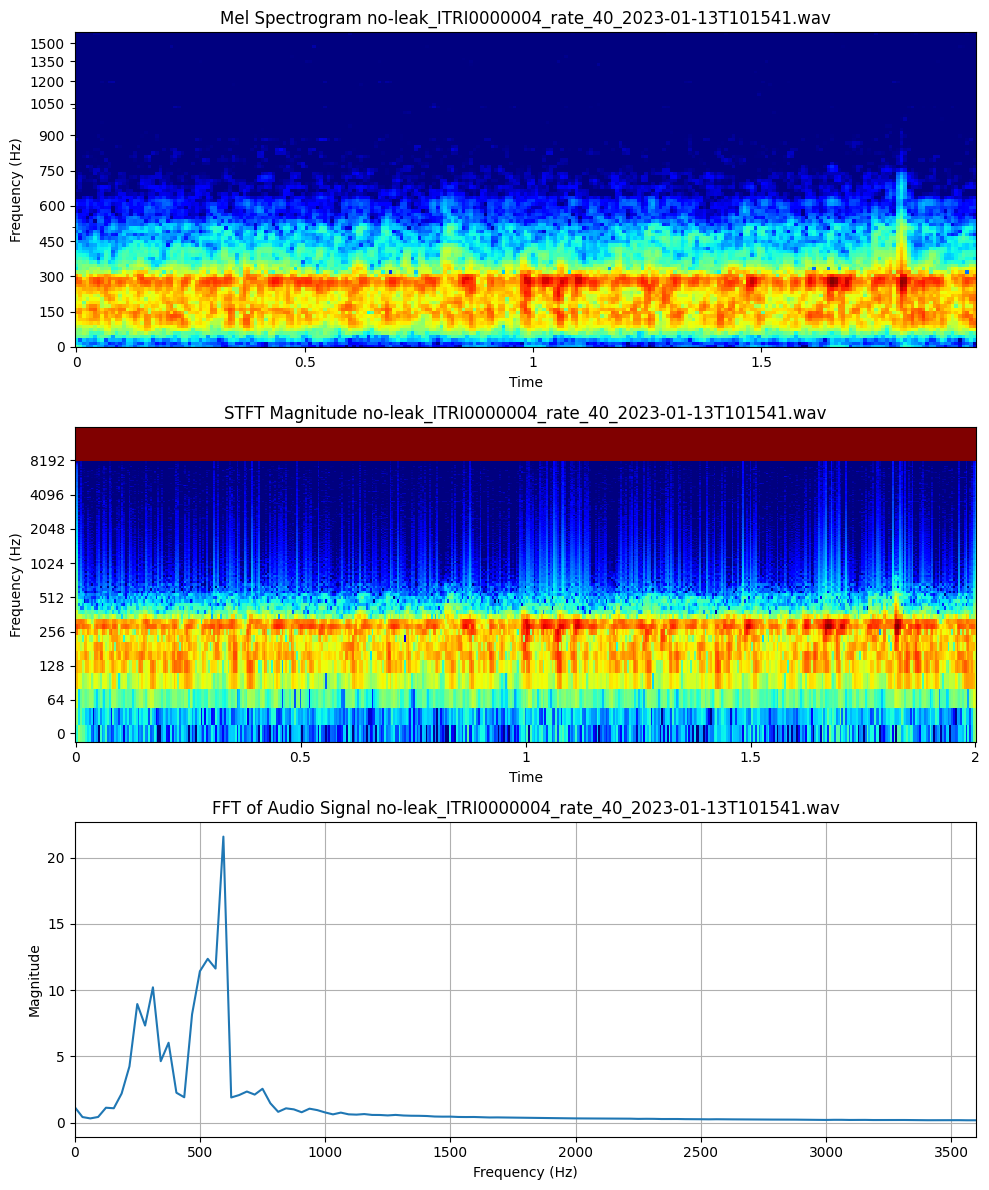

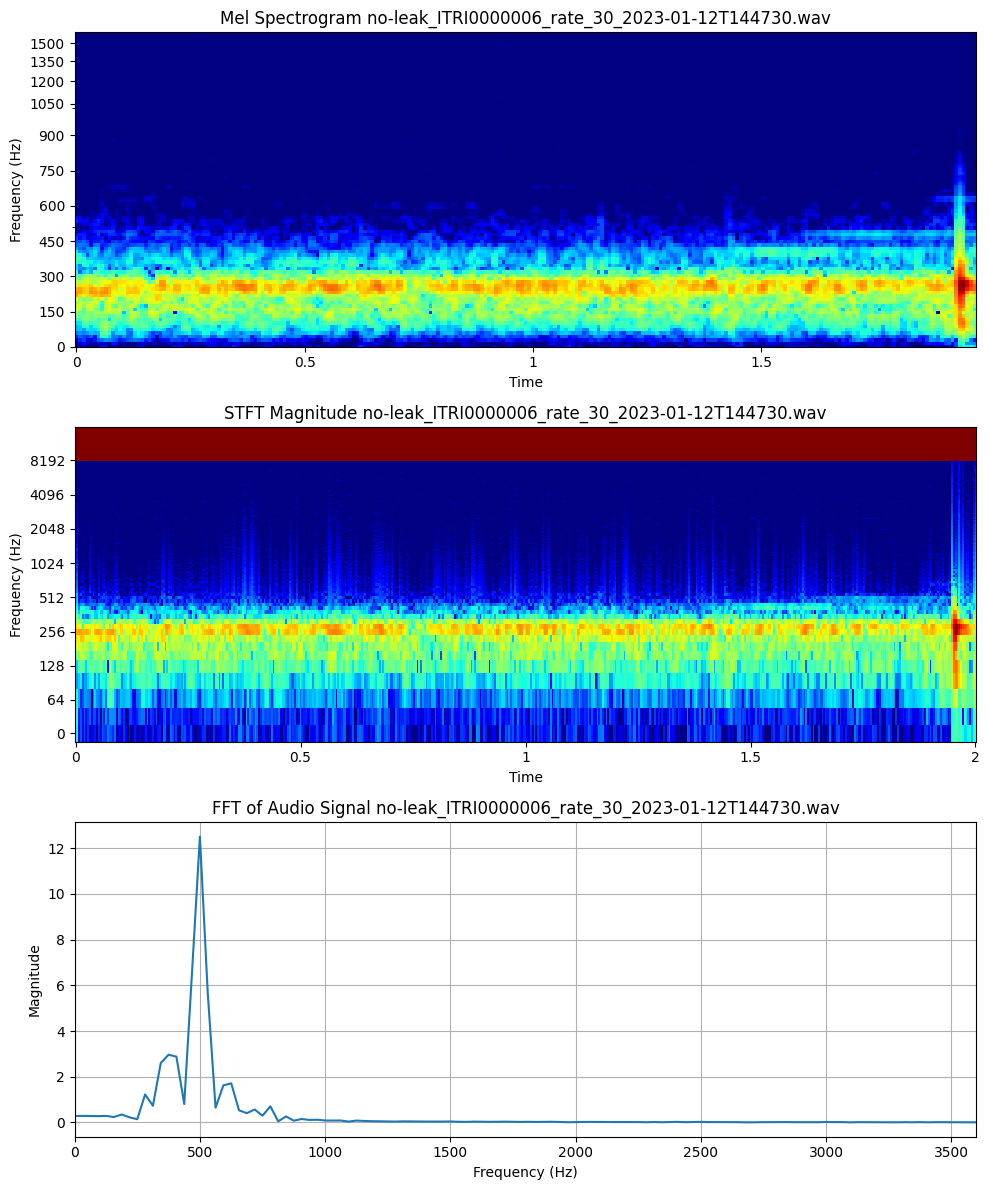

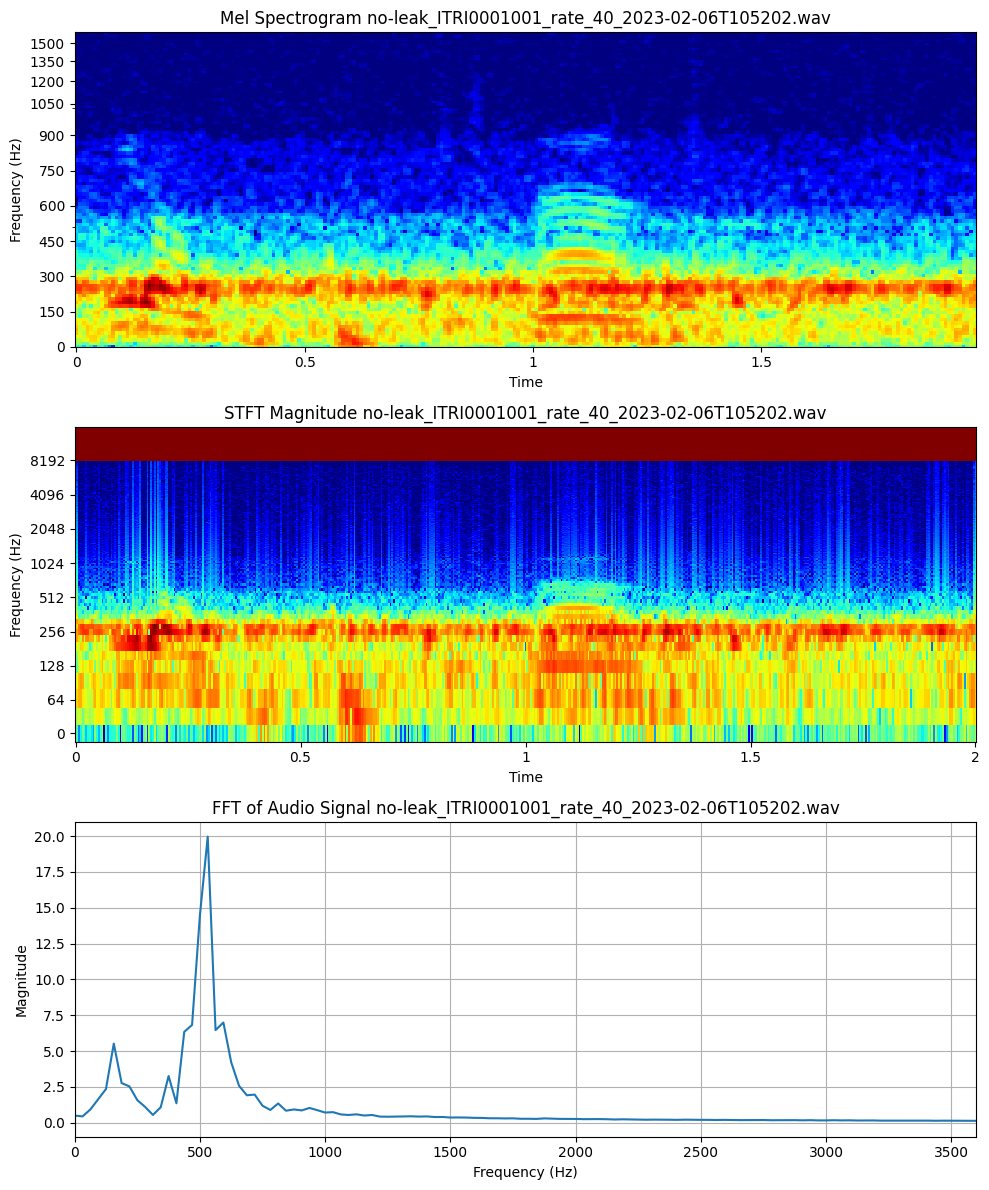

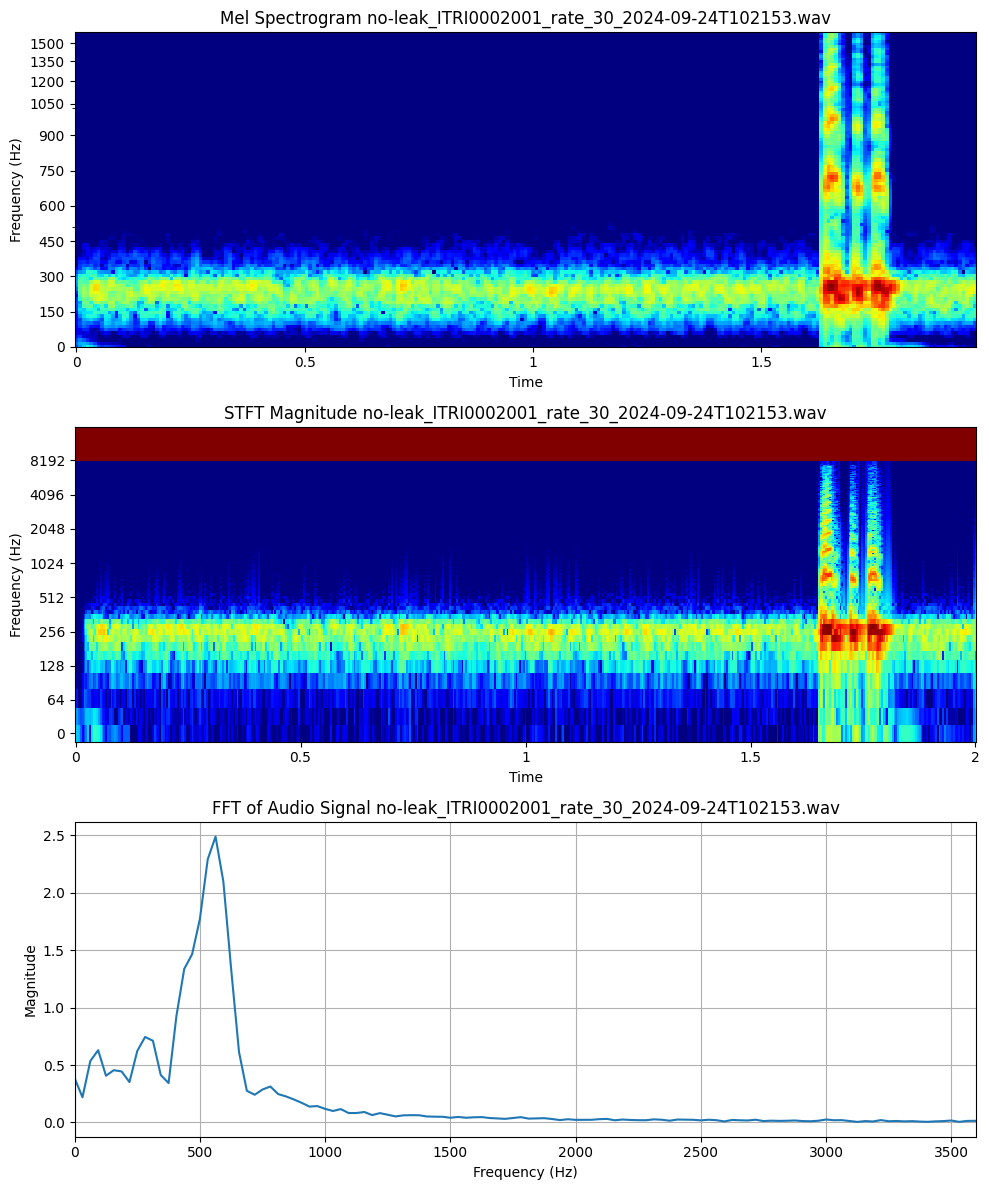

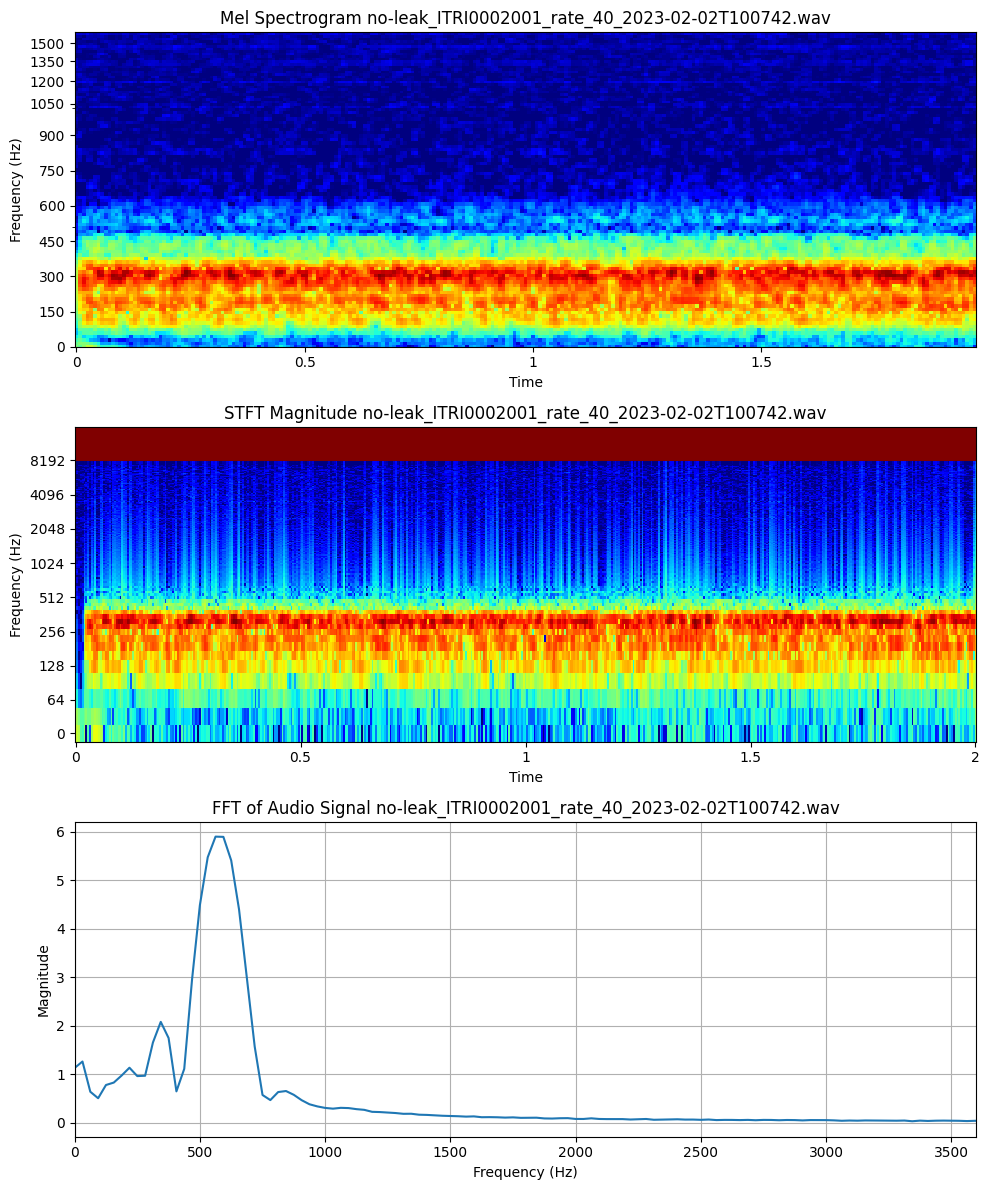

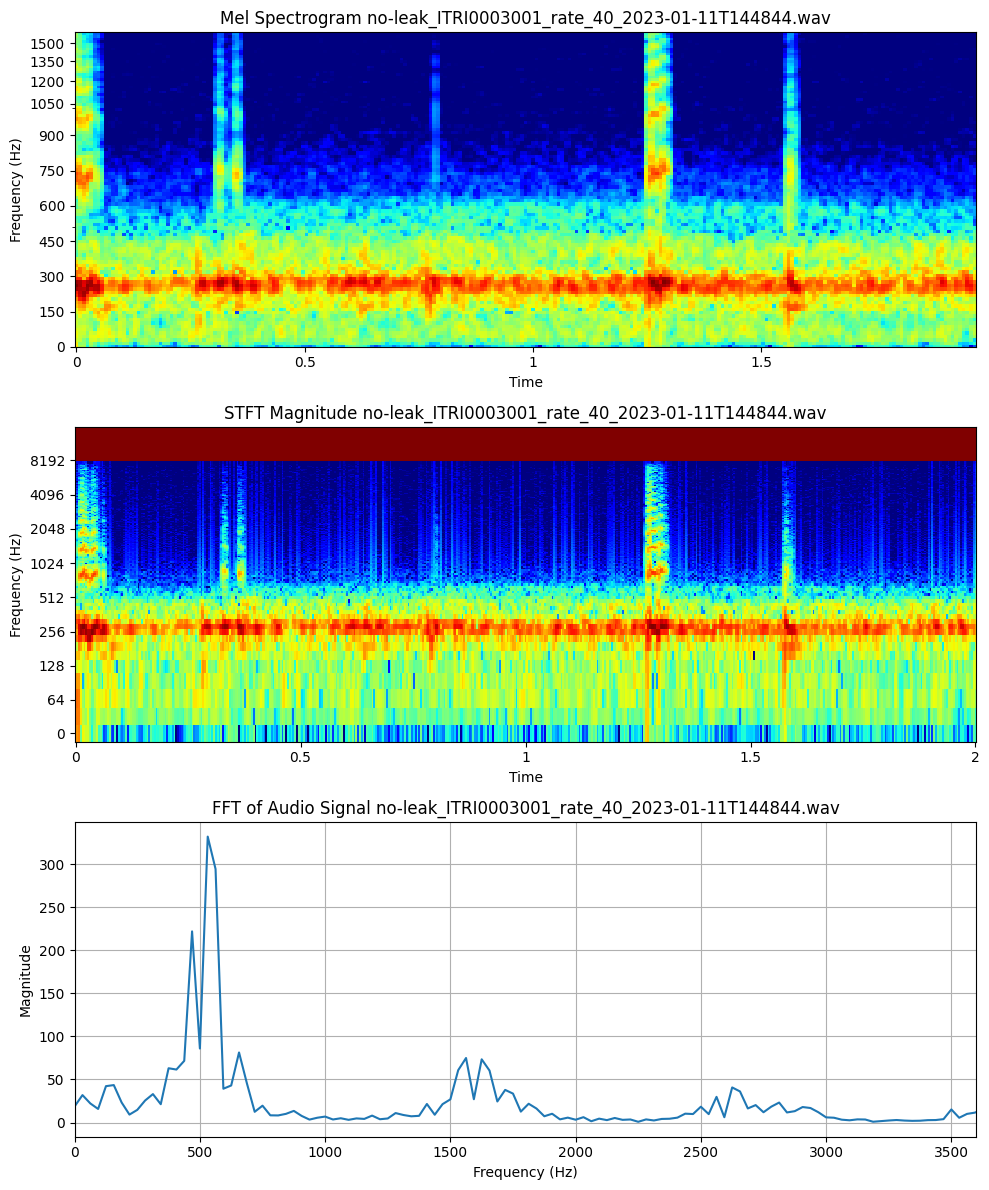

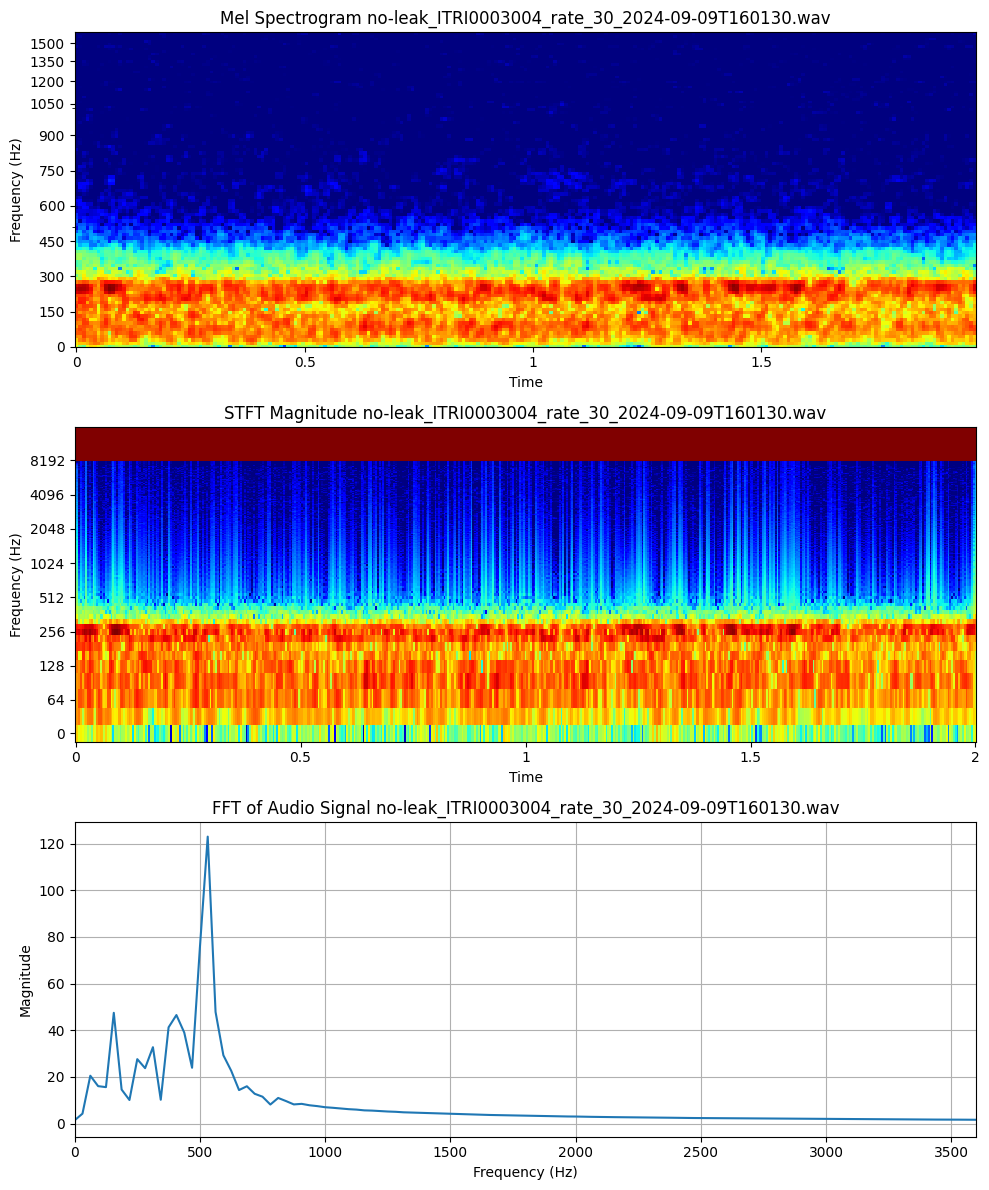

In [45]:
for wav, file_name in wav_files:
    plot_mel_stft_fft(wav, file_name, class_type='no-leak')

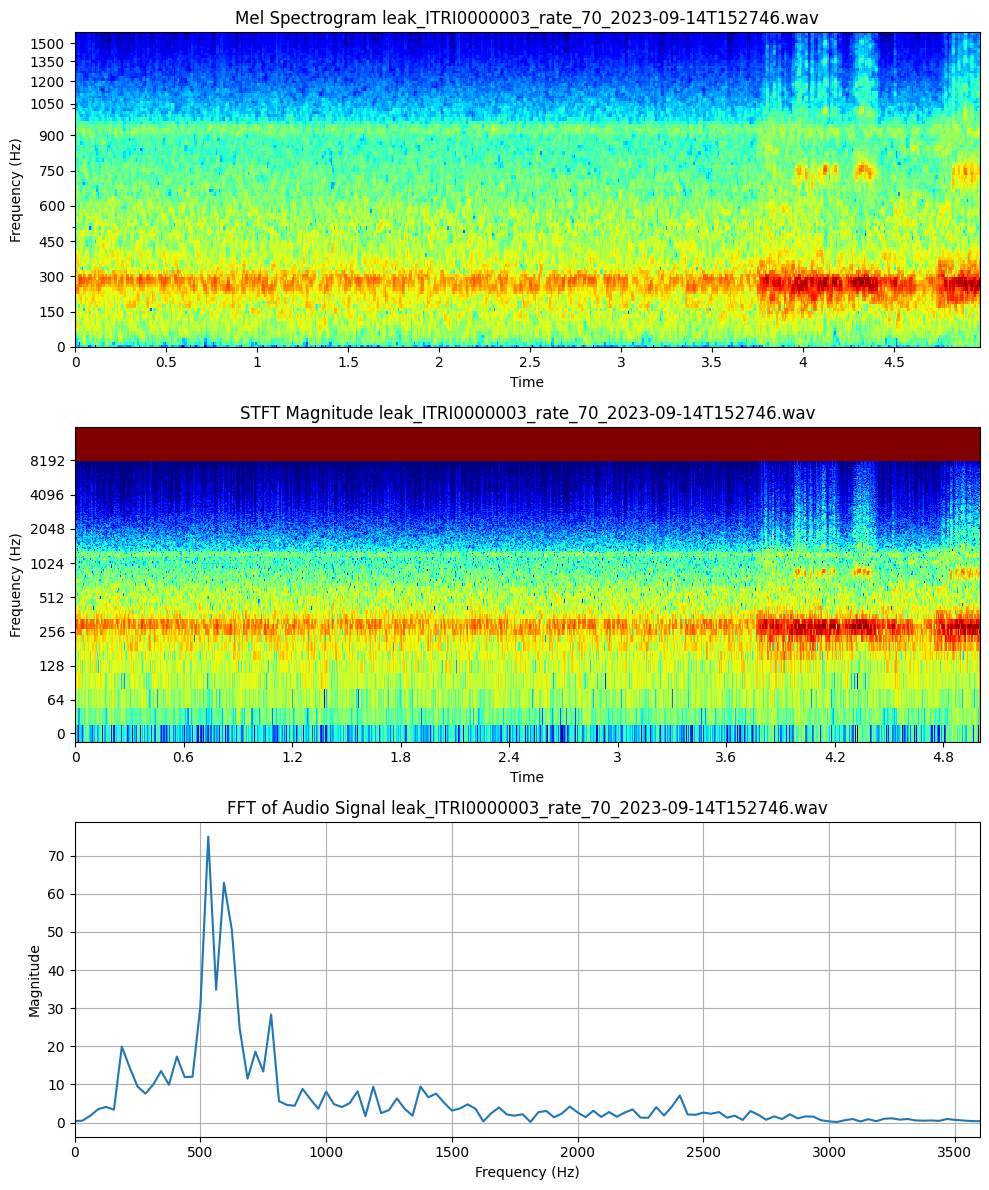

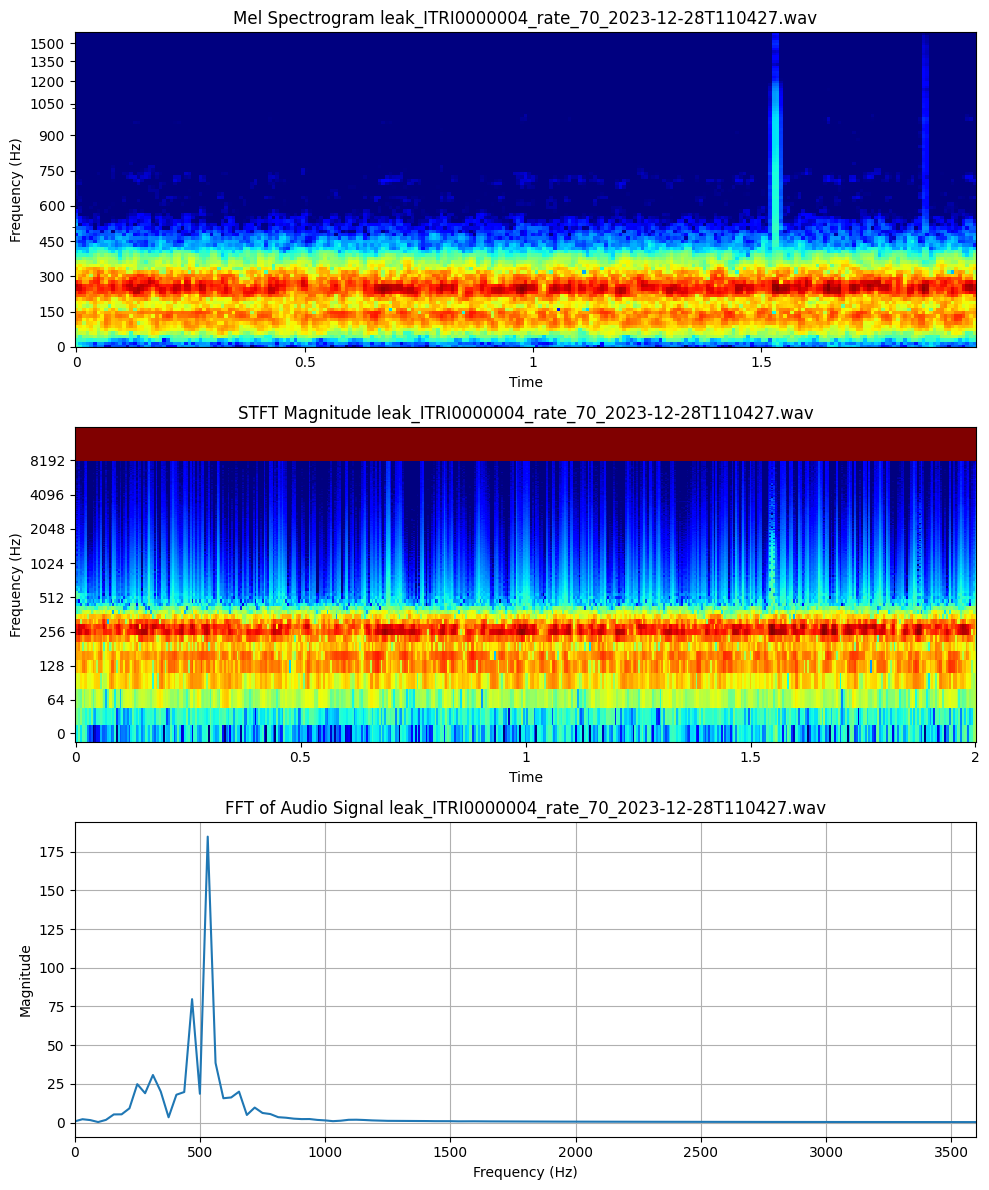

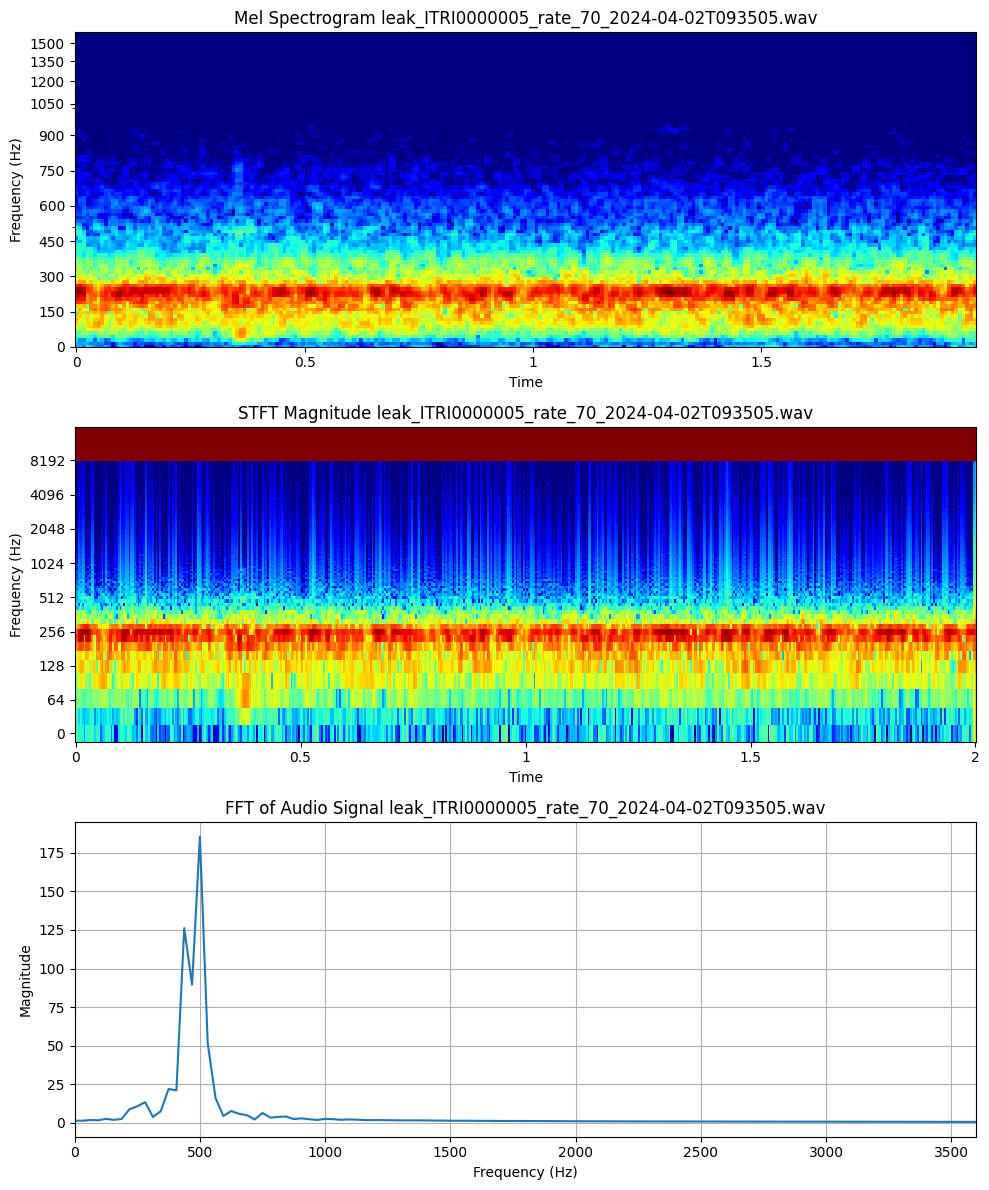

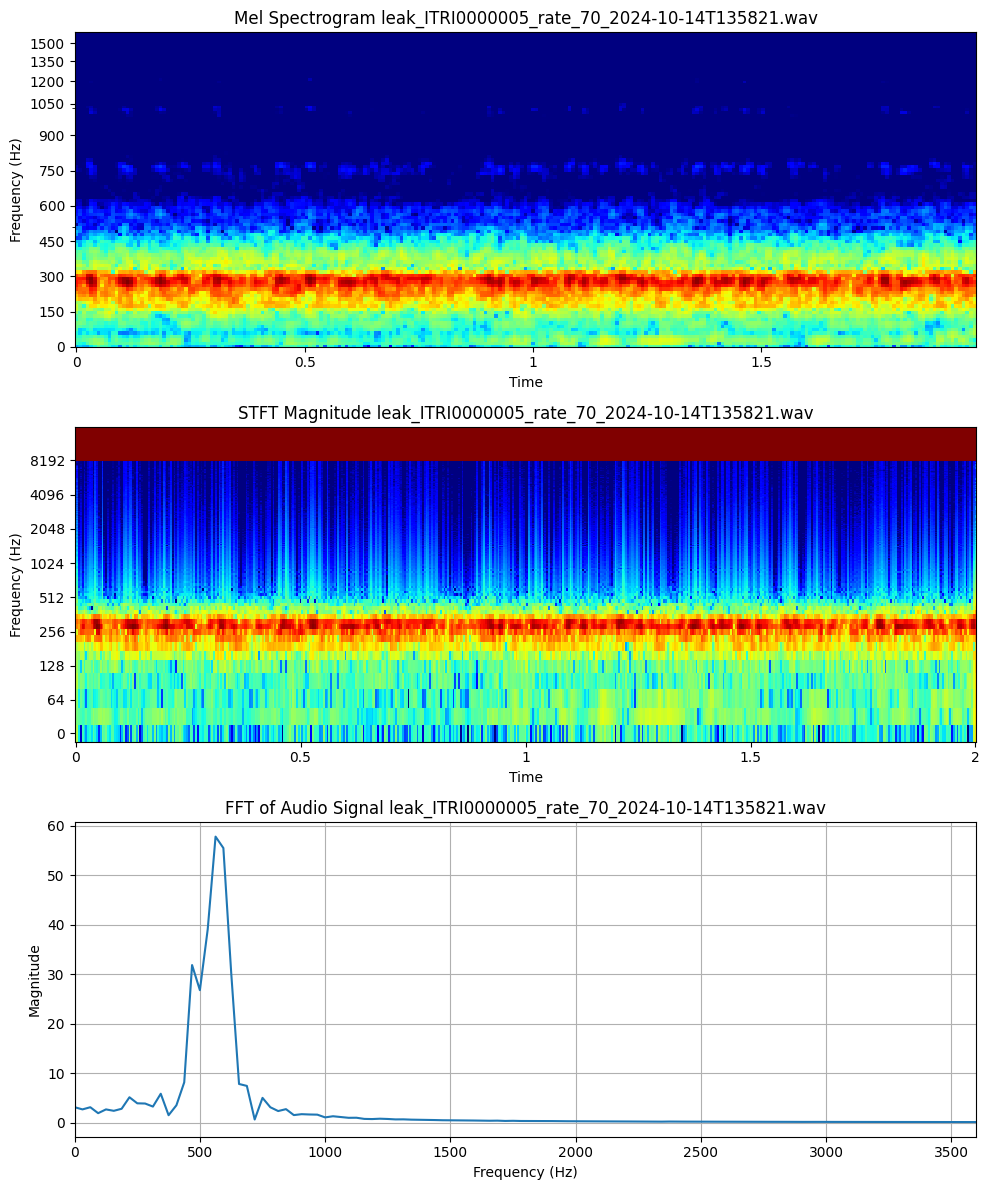

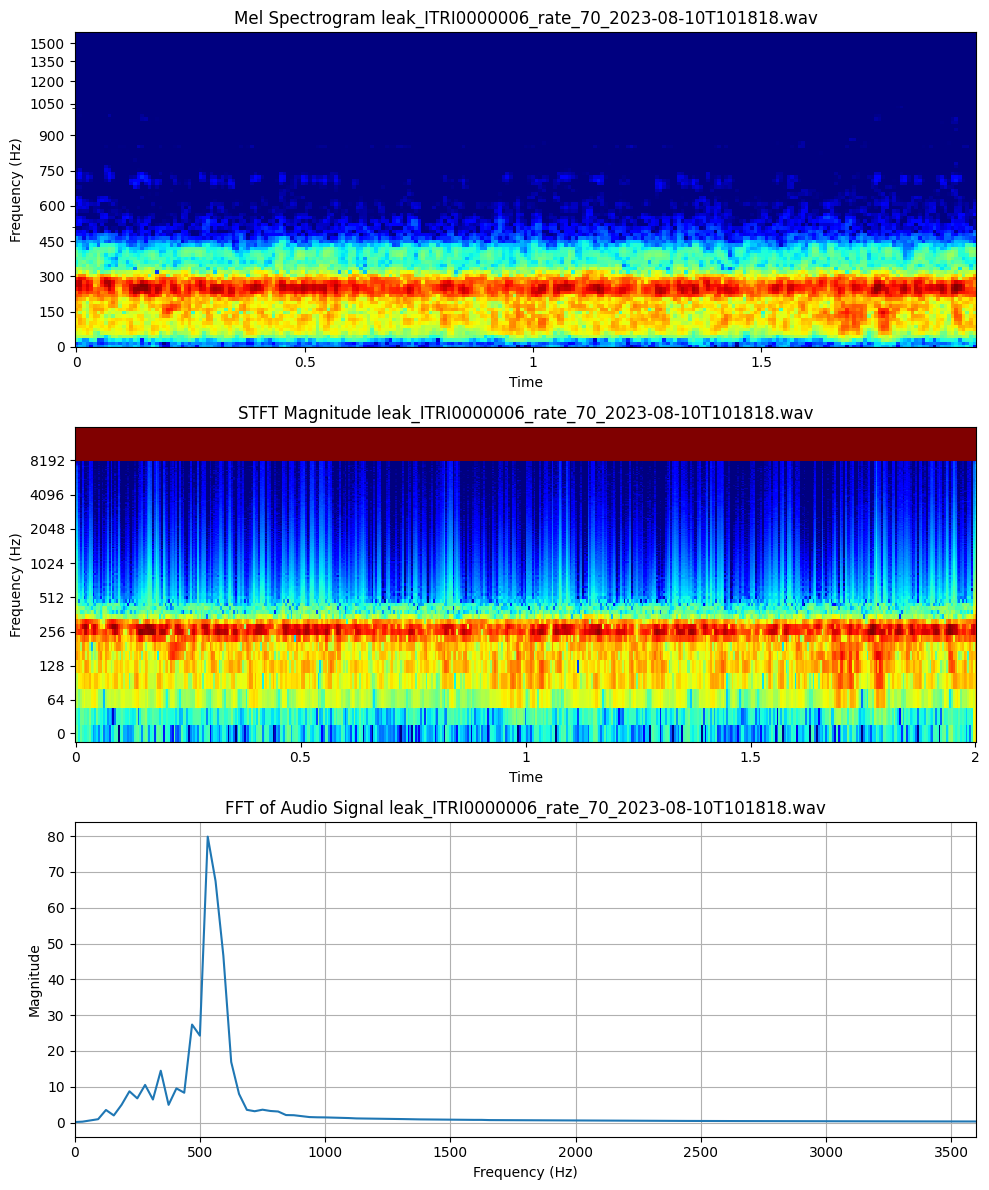

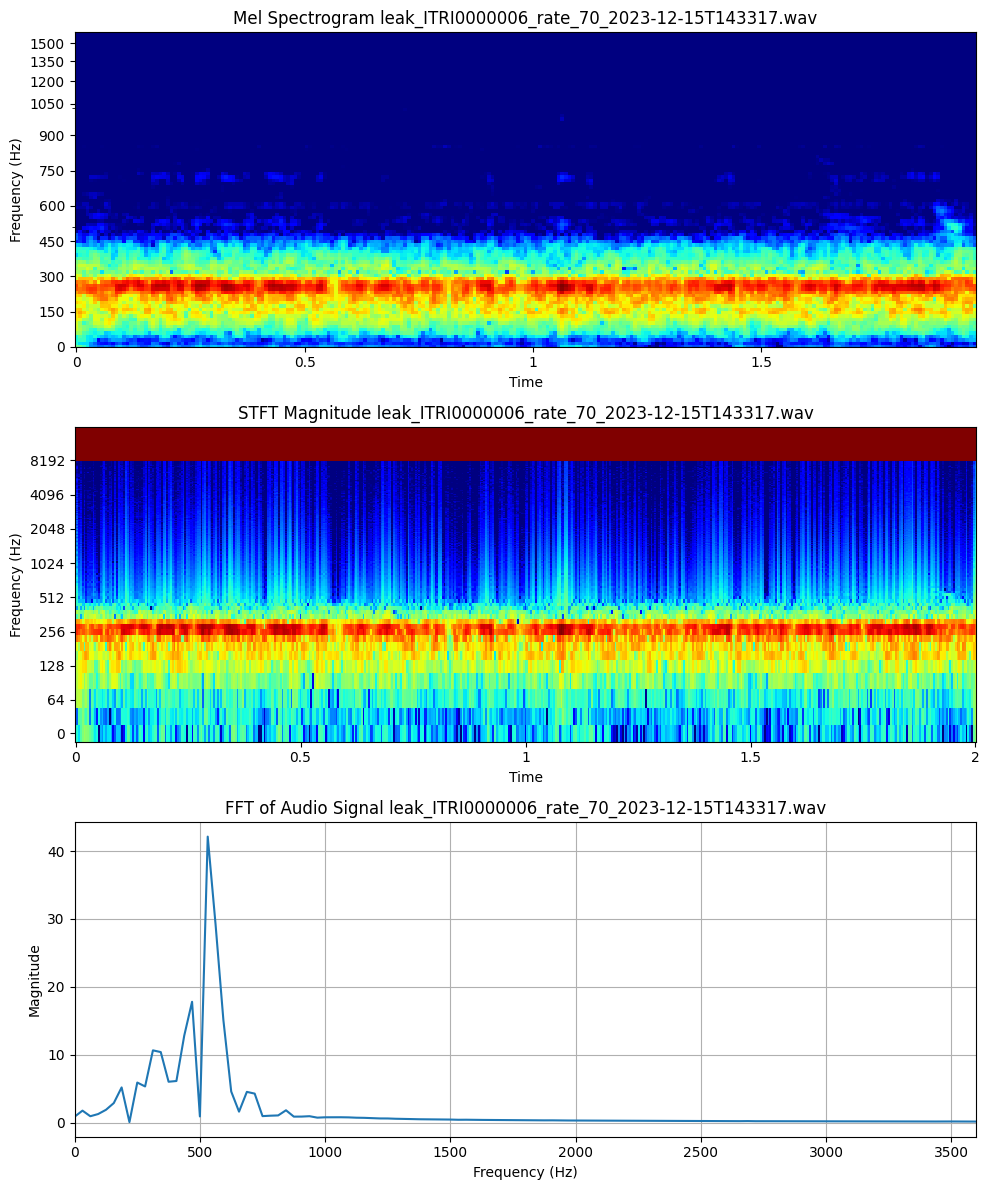

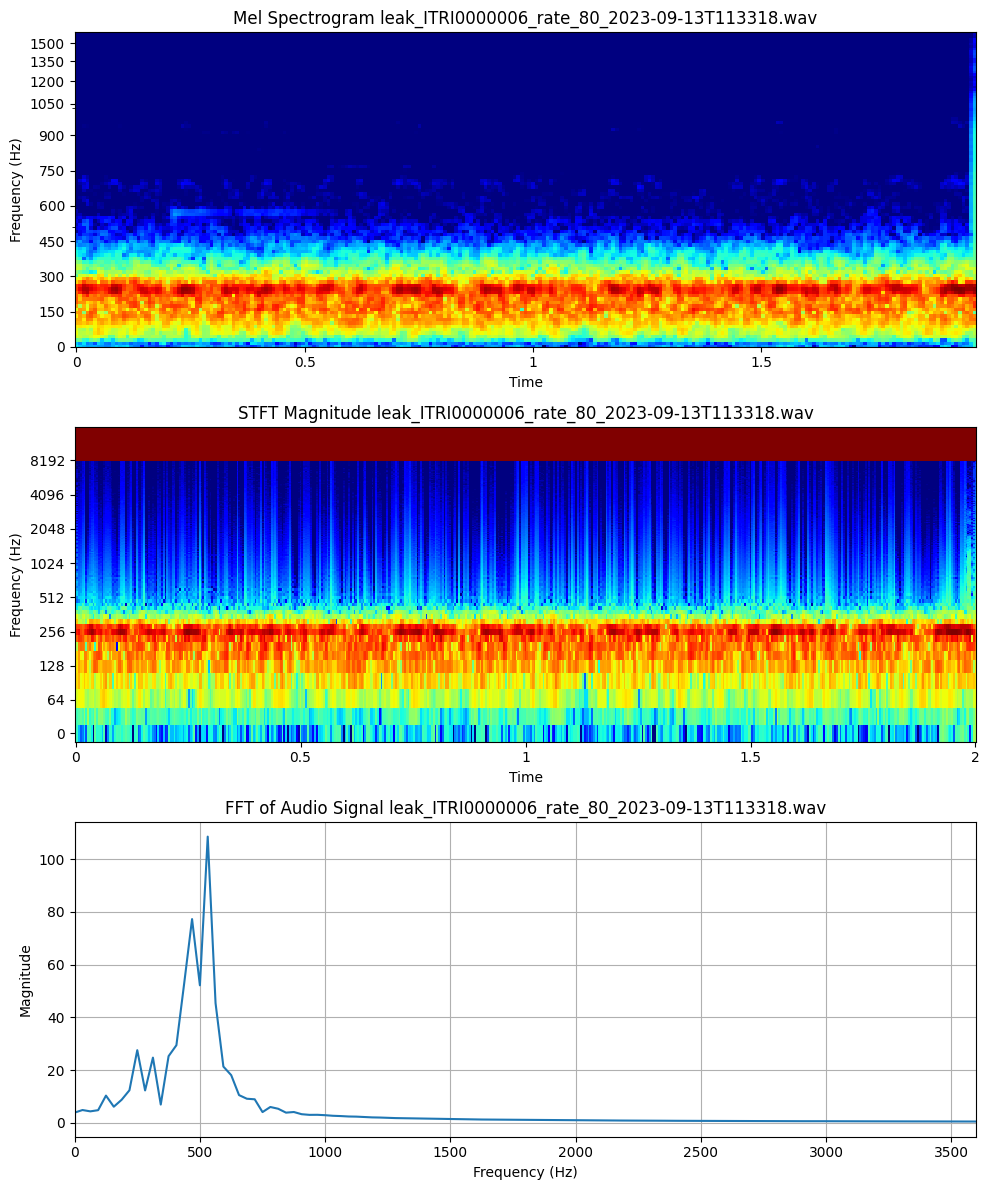

In [46]:
for wav, file_name in leak_wav_files:
    plot_mel_stft_fft(wav, file_name, class_type='leak')